In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import dezero
from dezero import cuda, Layer, Model
import dezero.functions as F
import dezero.layers as L
import dezero.models as M
from dezero import DataLoader, Function
from dezero.models import Sequential
from dezero.optimizers import Adam
from dezero.core import Parameter

use_gpu = cuda.gpu_enable
print(use_gpu)

True


In [2]:
class InstanceNorm2D(Function):
    def __init__(self, mean, var, decay, eps):
        self.avg_mean = mean
        self.avg_var = var
        self.decay = decay
        self.eps = eps
        self.inv_std = None

    def forward(self, x, gamma, beta):
        assert x.ndim == 2 or x.ndim == 4

        x_ndim = x.ndim
        if x_ndim == 4:
            N, C, H, W = x.shape
            # (N, C, H, W) -> (H*W, N, C)
            x = x.transpose(2, 3, 0, 1).reshape(-1, N, C)

        xp = cuda.get_array_module(x)

        if dezero.Config.train:
            mean = x.mean(axis=0)
            var = x.var(axis=0)
            inv_std = 1 / xp.sqrt(var + self.eps)
            xc = (x - mean) * inv_std

            m = x.size // gamma.size
            s = m - 1. if m - 1. > 1. else 1.
            adjust = m / s  # unbiased estimation
            self.avg_mean *= self.decay
            self.avg_mean += (1 - self.decay) * mean
            self.avg_var *= self.decay
            self.avg_var += (1 - self.decay) * adjust * var
            self.inv_std = inv_std
        else:
            inv_std = 1 / xp.sqrt(self.avg_var + self.eps)
            xc = (x - self.avg_mean) * inv_std
        y = gamma * xc + beta

        if x_ndim == 4:
            # (N*H*W, C) -> (N, C, H, W)
            y = y.reshape(H, W, N, C).transpose(2, 3, 0, 1)
        return y

    def backward(self, gy):
        gy_ndim = gy.ndim
        if gy_ndim == 4:
            N, C, H, W = gy.shape
            gy = gy.transpose(2, 3, 0, 1).reshape(-1, N, C)

        x, gamma, beta = self.inputs
        batch_size = len(gy)

        if x.ndim == 4:
            N, C, H, W = x.shape
            x = x.transpose(2, 3, 0, 1).reshape(-1, N, C)
        mean = x.sum(axis=0) / batch_size
        xc = (x - mean) * self.inv_std
        
        gbeta = F.sum(gy, axis=0)
        ggamma = F.sum(xc * gy, axis=0)
        gx = gy - gbeta / batch_size - xc * ggamma / batch_size
        gx *= gamma * self.inv_std

        if gy_ndim == 4:
            gx = gx.reshape(H, W, N, C).transpose(2, 3, 0, 1)
        return gx, ggamma, gbeta
    
def instance_norm2d(x, gamma, beta, mean, var, decay=0.9, eps=2e-5):
    return InstanceNorm2D(mean, var, decay, eps)(x, gamma, beta)

class InstanceNorm2DLayer(Layer):
    def __init__(self):
        super().__init__()
        # `.avg_mean` and `.avg_var` are `Parameter` objects, so they will be
        # saved to a file (using `save_weights()`).
        # But they don't need grads, so they're just used as `ndarray`.
        self.avg_mean = Parameter(None, name='avg_mean')
        self.avg_var = Parameter(None, name='avg_var')
        self.gamma = Parameter(None, name='gamma')
        self.beta = Parameter(None, name='beta')

    def _init_params(self, x):
        xp = cuda.get_array_module(x)
        D1 = x.shape[0]
        D2 = x.shape[1]
        if self.avg_mean.data is None:
            self.avg_mean.data = xp.zeros((D1, D2), dtype=x.dtype)
        if self.avg_var.data is None:
            self.avg_var.data = xp.ones((D1, D2), dtype=x.dtype)
        if self.gamma.data is None:
            self.gamma.data = xp.ones((D1, D2), dtype=x.dtype)
        if self.beta.data is None:
            self.beta.data = xp.zeros((D1, D2), dtype=x.dtype)

    def __call__(self, x):
        if self.avg_mean.data is None:
            self._init_params(x)
        return instance_norm2d(x, self.gamma, self.beta, self.avg_mean.data,
                            self.avg_var.data)

In [3]:
class ResnetBlock(Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = L.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, pad=1, nobias=True)
        self.bn1 = InstanceNorm2DLayer()
        self.conv2 = L.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, pad=1, nobias=True)
        self.bn2 = InstanceNorm2DLayer()

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(h + x)

In [4]:
#define generators
G_AB = Sequential(
    #encoding blocks
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    #residual blocks
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    # ResnetBlock(256, 256),
    # ResnetBlock(256, 256),
    # ResnetBlock(256, 256),

    #decoding blocks
    L.Deconv2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Deconv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Deconv2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    F.tanh,
)

G_BA = Sequential(
    #encoding blocks
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    #residual blocks
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    ResnetBlock(256, 256),
    # ResnetBlock(256, 256),
    # ResnetBlock(256, 256),
    # ResnetBlock(256, 256),

    #decoding blocks
    L.Deconv2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Deconv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.relu,

    L.Deconv2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    F.tanh,
)

In [5]:
#define discriminator
D_A = Sequential(
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

D_B = Sequential(
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    InstanceNorm2DLayer(),
    F.leaky_relu,

    L.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

In [6]:
G_AB.load_weights("./G_AB_manual.npz")
G_BA.load_weights("./G_BA_manual.npz")
D_A.load_weights("./D_A_manual.npz")
D_B.load_weights("./D_B_manual.npz")
G_AB.to_gpu()
G_BA.to_gpu()
D_A.to_gpu()
D_B.to_gpu()

In [7]:
#load Dataset
dataset_A = np.load('./Domain_A_900_128x128.npy')
dataset_B = np.load('./Domain_B_900_128x128.npy')

data_A = []
data_B = []

for i in range(min(len(dataset_A), len(dataset_B))):
    reshaped_A = np.transpose(dataset_A[i], (2,0,1))
    reshaped_B = np.transpose(dataset_B[i], (2,0,1))
    data_A.append((reshaped_A, reshaped_B))

batch_size = 16

dataloader = DataLoader(data_A, batch_size=batch_size, shuffle=True)

In [8]:
if use_gpu:
    G_AB.to_gpu()
    G_BA.to_gpu()
    D_A.to_gpu()
    D_B.to_gpu()
    dataloader.to_gpu()
    xp = cuda.cupy
else:
    xp = np

In [9]:
# def init_weight(D_A, D_B, G_AB, G_BA):
#     # Input dummy data to initialize weights
#     for x_A, x_B in dataloader:
#         fake_images_B = G_AB(x_A)
#         D_B(fake_images_B)
#         fake_images_A = G_BA(x_B)
#         D_A(fake_images_A)
#         break

#     for l in D_A.layers + D_B.layers + G_AB.layers + G_BA.layers:
#         classname = l.__class__.__name__
#         if classname.lower() in ('conv2d', 'linear', 'deconv2d'):
#             l.W.data = 0.02 * xp.random.randn(*l.W.data.shape)

# init_weight(D_A, D_B, G_AB, G_BA)
# G_AB.to_gpu()
# G_BA.to_gpu()
# D_A.to_gpu()
# D_B.to_gpu()

epoch: 0
cnt: 28 loss_d: 58.9615, loss_g: 2691.4939


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


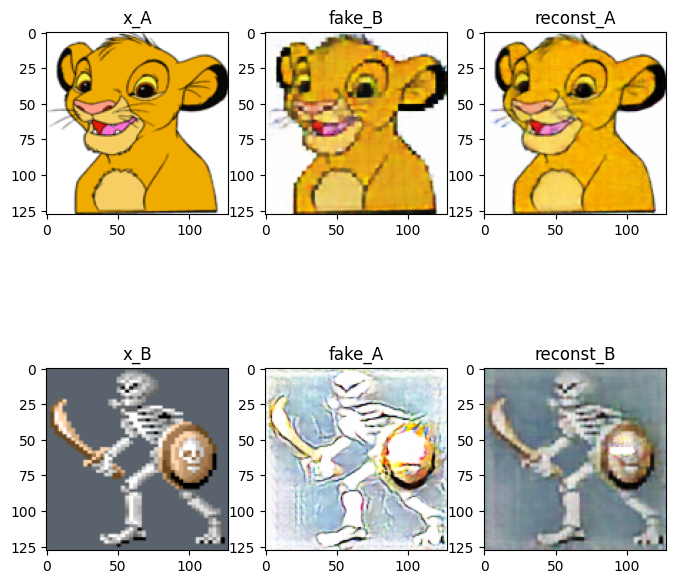

cnt: 56 loss_d: 56.6338, loss_g: 2684.1541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


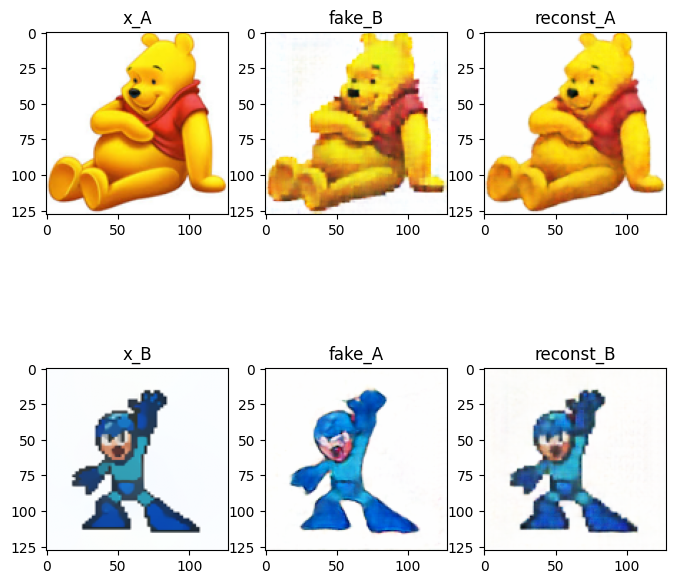

epoch: 1
cnt: 28 loss_d: 52.4772, loss_g: 2677.2610


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


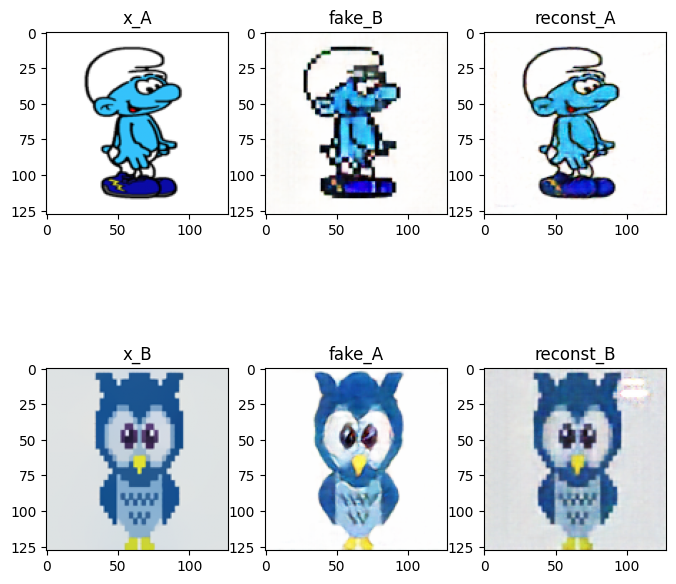

cnt: 56 loss_d: 53.4998, loss_g: 2652.1111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


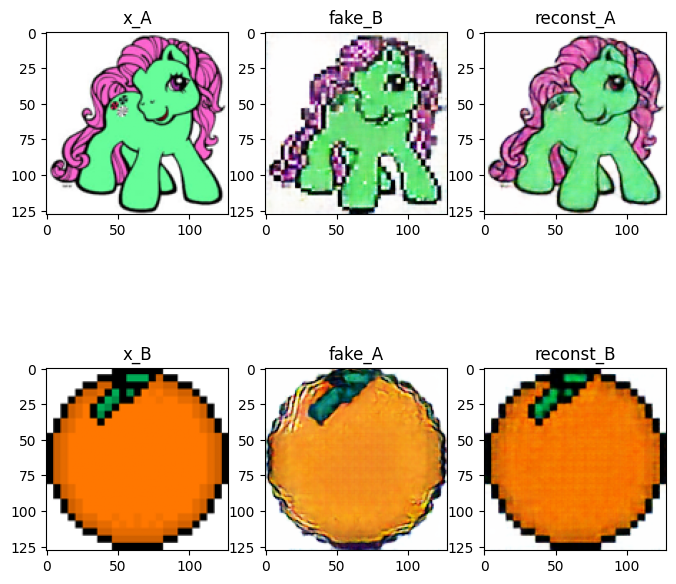

epoch: 2
cnt: 28 loss_d: 55.5220, loss_g: 2712.7814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


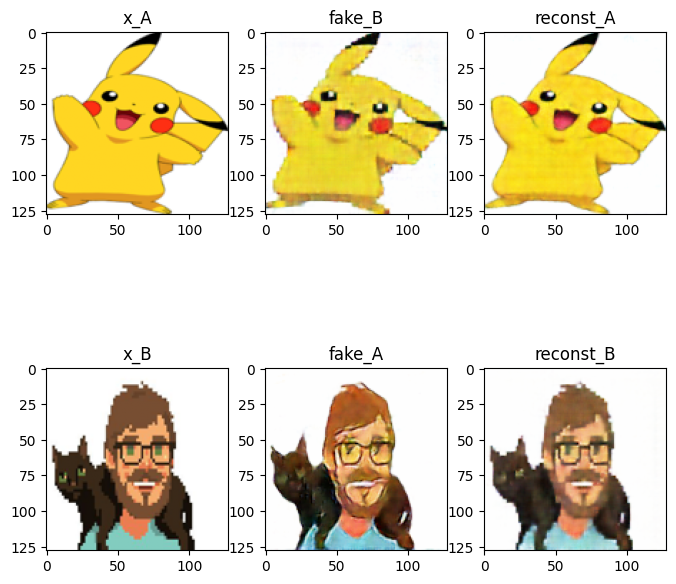

cnt: 56 loss_d: 55.6148, loss_g: 2645.5233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


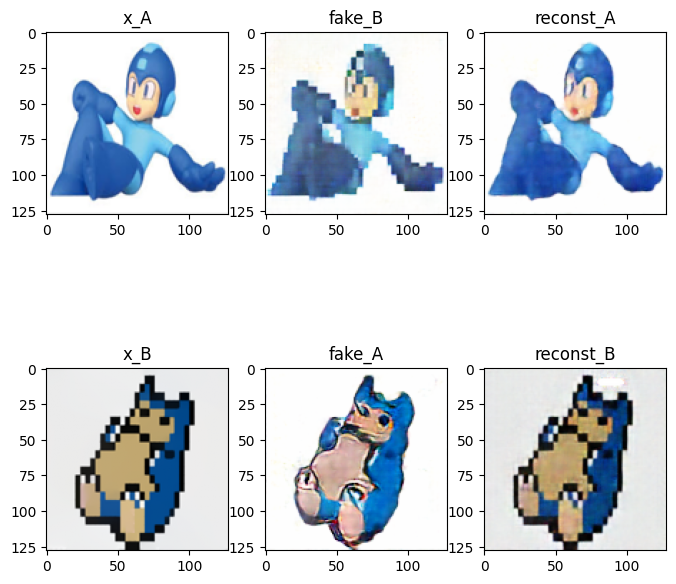

epoch: 3
cnt: 28 loss_d: 52.7983, loss_g: 2789.4409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


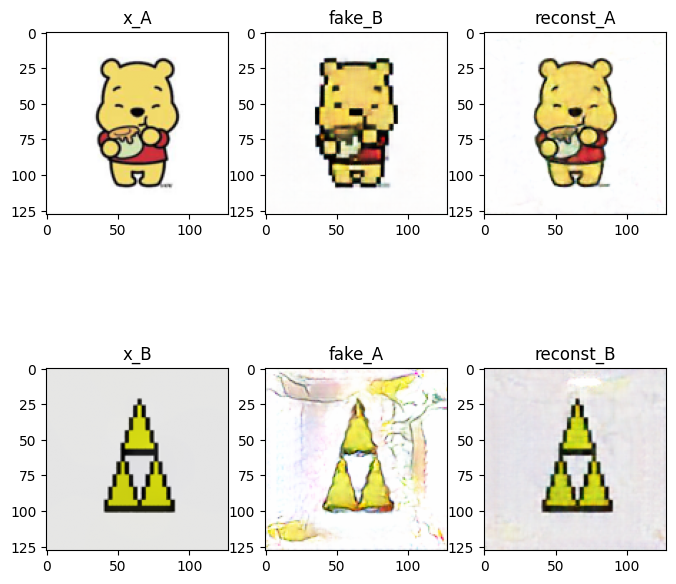

cnt: 56 loss_d: 53.8301, loss_g: 2656.4469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


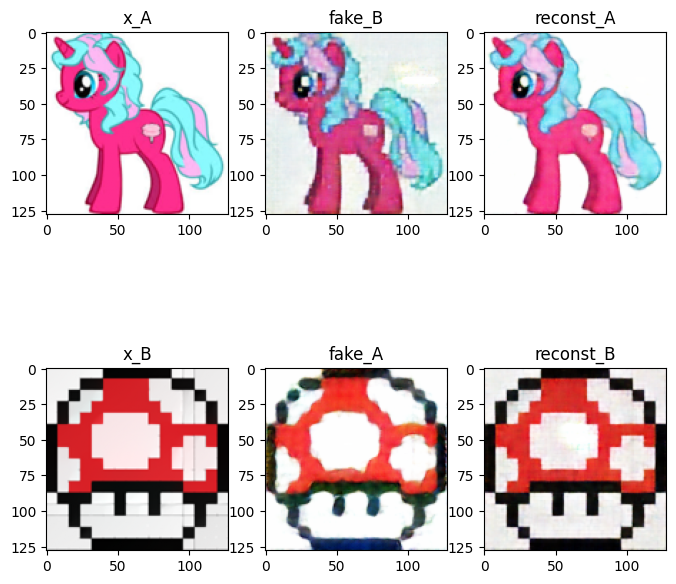

epoch: 4
cnt: 28 loss_d: 51.9637, loss_g: 2583.5315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


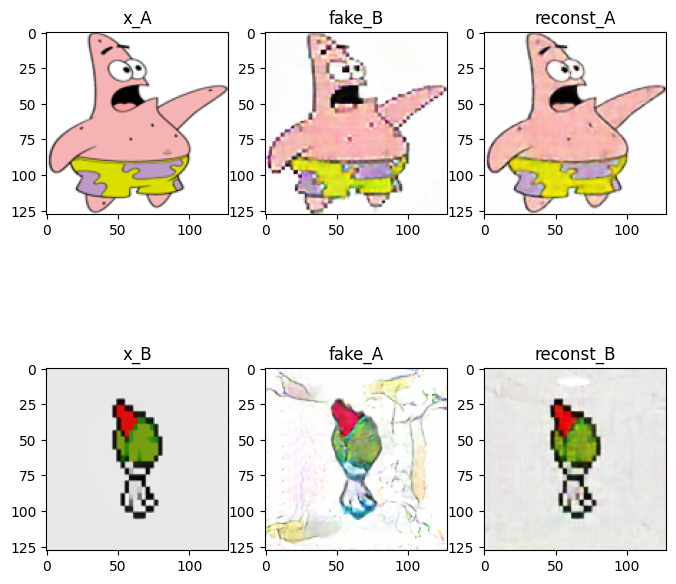

cnt: 56 loss_d: 53.1837, loss_g: 2693.7038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


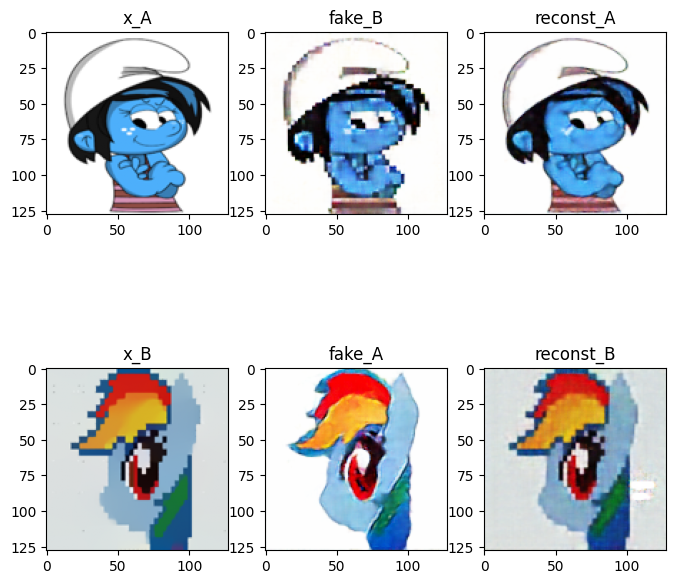

epoch: 5
cnt: 28 loss_d: 47.6291, loss_g: 2791.4310


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


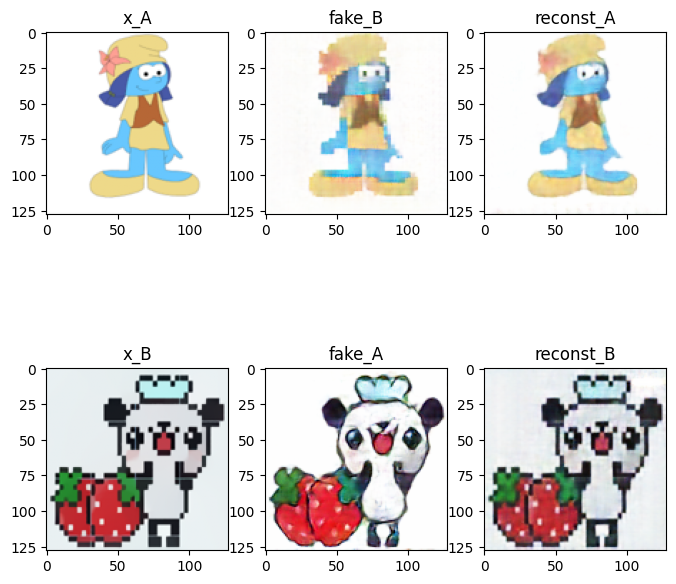

cnt: 56 loss_d: 46.8115, loss_g: 2869.8956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


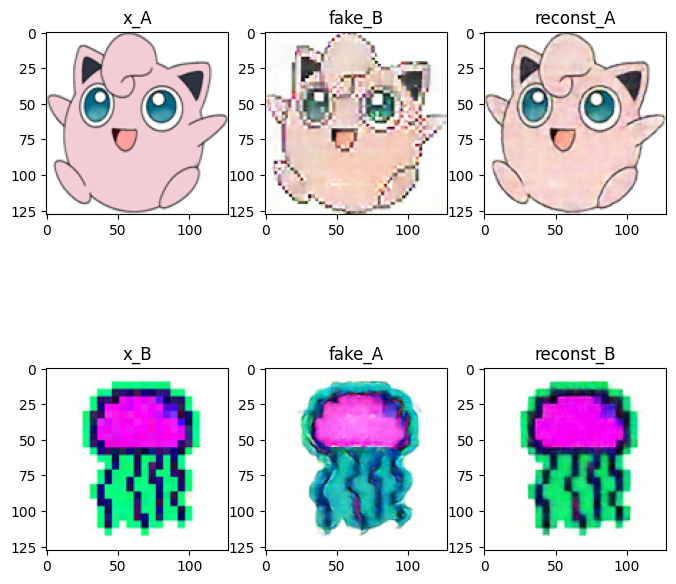

epoch: 6
cnt: 28 loss_d: 59.2799, loss_g: 2518.2931


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


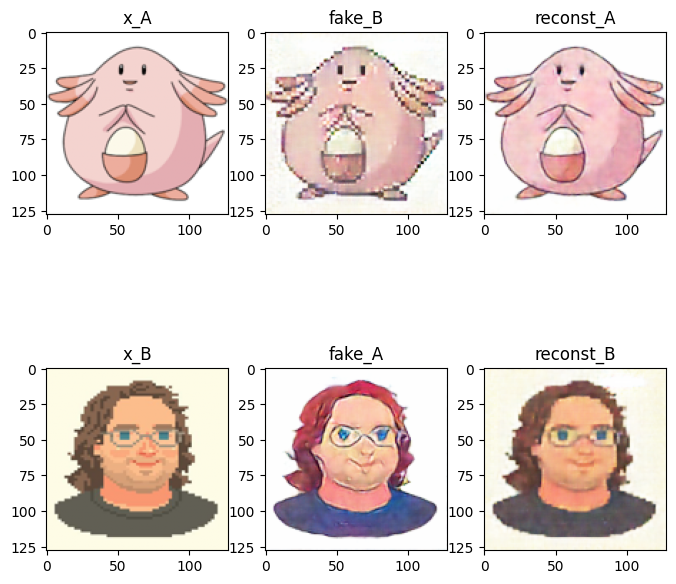

cnt: 56 loss_d: 55.8786, loss_g: 2570.7251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


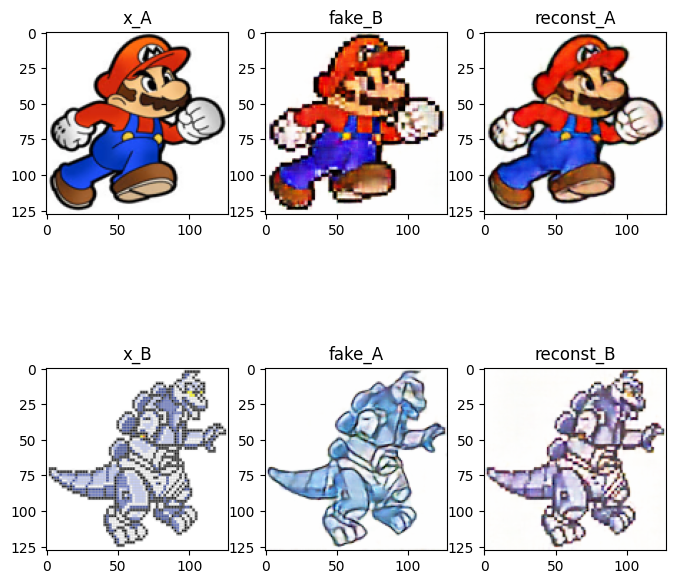

epoch: 7
cnt: 28 loss_d: 56.0320, loss_g: 2581.3484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


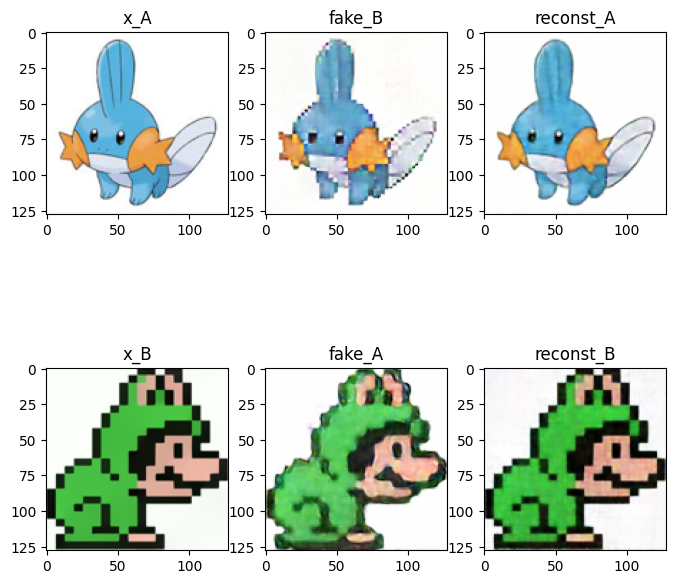

cnt: 56 loss_d: 56.1478, loss_g: 2543.0373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


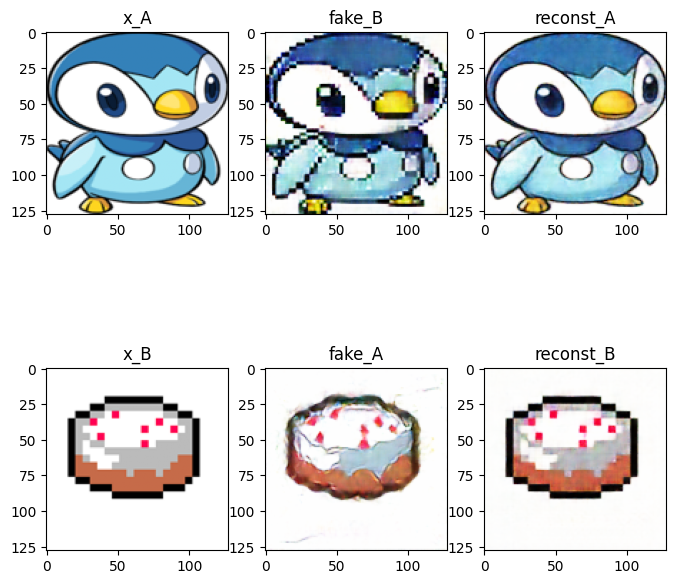

epoch: 8
cnt: 28 loss_d: 51.7764, loss_g: 2493.5118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


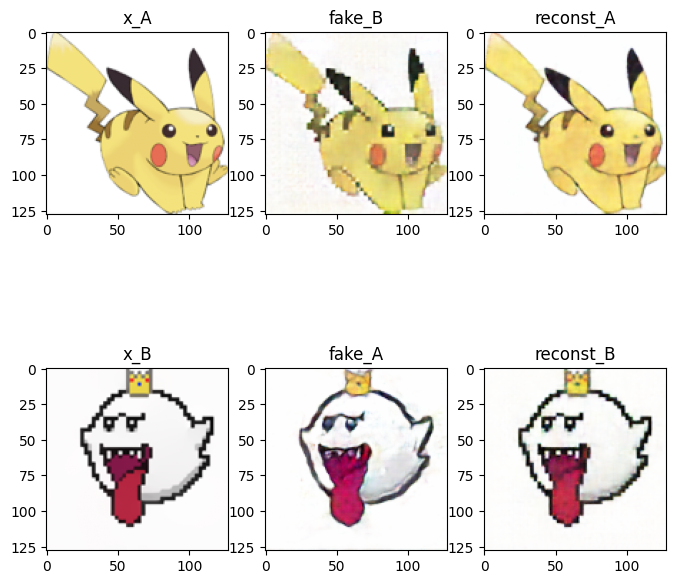

cnt: 56 loss_d: 55.4879, loss_g: 2538.9343


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


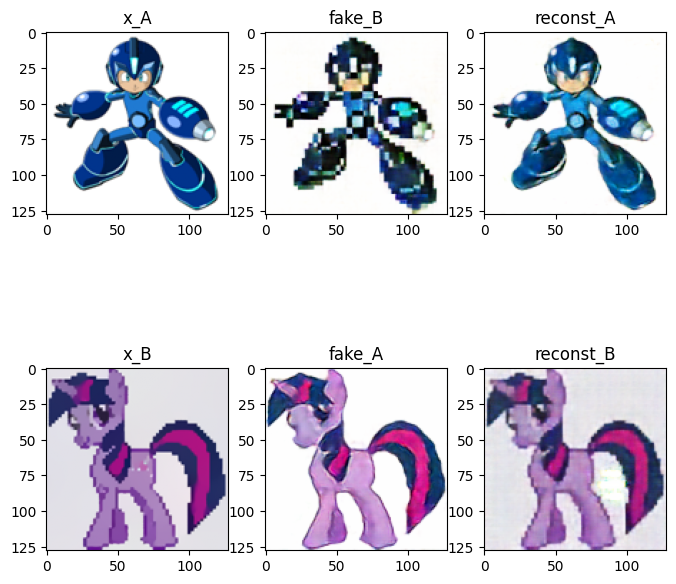

epoch: 9
cnt: 28 loss_d: 53.7067, loss_g: 2661.7611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


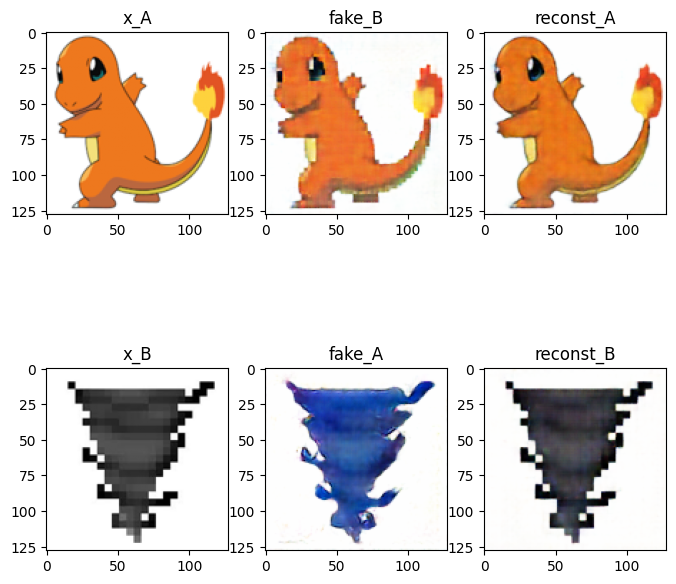

cnt: 56 loss_d: 55.3652, loss_g: 2625.9678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


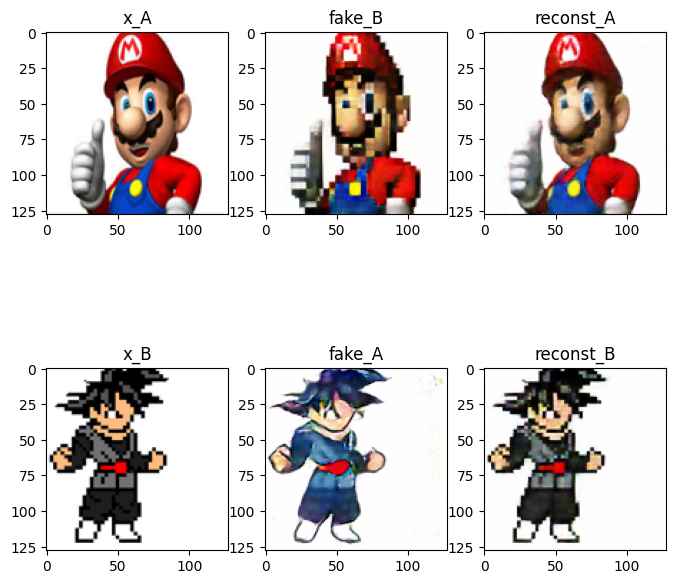

In [16]:
#define optimizer
opt_G_AB = Adam(alpha=0.0002, beta1=0.5).setup(G_AB)
opt_G_BA = Adam(alpha=0.0002, beta1=0.5).setup(G_BA)
opt_D_A = Adam(alpha=0.0002, beta1=0.5).setup(D_A)
opt_D_B = Adam(alpha=0.0002, beta1=0.5).setup(D_B)

max_epoch = 10

label_real = xp.ones((batch_size, 1, 14, 14)).astype(int)
label_fake = xp.zeros((batch_size, 1, 14, 14)).astype(int)

loss_d_stack = []
loss_g_stack = []

min_loss = 10000

for epoch in range(max_epoch):

    print('epoch:', epoch)

    avg_loss_d = 0
    avg_loss_g = 0
    cnt = 0

    dataloader.reset()

    for x_A, x_B in dataloader:
        cnt += 1

        if x_A.shape[0] != batch_size:
          continue

        #============ train D ============#
        # train with real image
        pred_D_A = D_A(x_A)
        D_A_loss = F.mean_squared_error(pred_D_A, label_real)

        pred_D_B = D_B(x_B)
        D_B_loss = F.mean_squared_error(pred_D_B, label_real)

        D_total_loss = D_A_loss + D_B_loss  
        D_A.cleargrads()
        D_B.cleargrads()
        G_AB.cleargrads()
        G_BA.cleargrads()
        D_total_loss.backward()
        opt_D_A.update()
        opt_D_B.update()

        # train with fake image
        fake_x_A = G_BA(x_B)
        pred_D_A = D_A(fake_x_A)
        D_A_loss = F.mean_squared_error(pred_D_A, label_fake)

        fake_x_B = G_AB(x_A)
        pred_D_B = D_B(fake_x_B)
        D_B_loss = F.mean_squared_error(pred_D_B, label_fake)

        D_total_loss = D_A_loss + D_B_loss
        D_A.cleargrads()
        D_B.cleargrads()
        G_AB.cleargrads()
        G_BA.cleargrads()
        D_total_loss.backward()
        opt_D_A.update()
        opt_D_B.update()

        #============ train G ============#
        # train A-B-A cycle
        fake_B = G_AB(x_A)
        pred_fake_D_B = D_B(fake_B)
        reconst_A = G_BA(fake_B)
        idt_B = G_AB(x_B)

        G_loss = F.mean_squared_error(pred_fake_D_B, label_real) + F.mean_absolute_error(reconst_A, x_A) + F.mean_absolute_error(idt_B, x_B)

        D_A.cleargrads()
        D_B.cleargrads()
        G_AB.cleargrads()
        G_BA.cleargrads()
        G_loss.backward()
        opt_G_AB.update()
        opt_G_BA.update()

        # train B-A-B cycle
        fake_A = G_BA(x_B)
        pred_fake_D_A = D_A(fake_A)
        reconst_B = G_AB(fake_A)
        idt_A = G_BA(x_A)

        G_loss = F.mean_squared_error(pred_fake_D_A, label_real) + F.mean_absolute_error(reconst_B, x_B) + F.mean_absolute_error(idt_A, x_A)

        D_A.cleargrads()
        D_B.cleargrads()
        G_AB.cleargrads()
        G_BA.cleargrads()
        G_loss.backward()
        opt_G_AB.update()
        opt_G_BA.update()

        avg_loss_d += D_total_loss.data
        avg_loss_g += G_loss.data
        
        interval = 28 if use_gpu else 5

        if cnt % interval == 0:
            if G_loss.data < min_loss:
                min_loss = G_loss.data
                G_BA.save_weights('G_BA_manual.npz')
                G_AB.save_weights('G_AB_manual.npz')
                D_A.save_weights('D_A_manual.npz')
                D_B.save_weights('D_B_manual.npz')
                G_AB.to_gpu()
                G_BA.to_gpu()
                D_A.to_gpu()
                D_B.to_gpu()

            print('cnt: {:d} loss_d: {:.4f}, loss_g: {:.4f}'.format(cnt, avg_loss_d / cnt, avg_loss_g / cnt))
            
            loss_d_stack.append(avg_loss_d / cnt)
            loss_g_stack.append(avg_loss_g / cnt)
            
            # see generated image
            fake_B = G_AB(x_A)
            fake_A = G_BA(x_B)
            reconst_A = G_BA(fake_B)
            reconst_B = G_AB(fake_A)
            fake_A = cuda.as_numpy(fake_A.data)
            fake_B = cuda.as_numpy(fake_B.data)
            reconst_A = cuda.as_numpy(reconst_A.data)
            reconst_B = cuda.as_numpy(reconst_B.data)
            x_A = cuda.as_numpy(x_A)
            x_B = cuda.as_numpy(x_B)
            plt.figure(figsize=(8, 8))   
            plt.subplot(2, 3, 1)
            plt.imshow(x_A[0].transpose(1,2,0))
            plt.title('x_A')
            plt.subplot(2, 3, 2)
            plt.imshow(fake_B[0].transpose(1,2,0))
            plt.title('fake_B')
            plt.subplot(2, 3, 3)
            plt.imshow(reconst_A[0].transpose(1,2,0))
            plt.title('reconst_A')
            plt.subplot(2, 3, 4)
            plt.imshow(x_B[0].transpose(1,2,0))
            plt.title('x_B')
            plt.subplot(2, 3, 5)
            plt.imshow(fake_A[0].transpose(1,2,0))
            plt.title('fake_A')
            plt.subplot(2, 3, 6)
            plt.imshow(reconst_B[0].transpose(1,2,0))
            plt.title('reconst_B')
            plt.show()
            
            



In [17]:
G_BA.save_weights('G_BA_manual.npz')
G_AB.save_weights('G_AB_manual.npz')
D_A.save_weights('D_A_manual.npz')
D_B.save_weights('D_B_manual.npz')
G_AB.to_gpu()
G_BA.to_gpu()
D_A.to_gpu()
D_B.to_gpu()